In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print("Tensorflow Version :", tf.__version__) 

2024-06-04 21:22:21.354531: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 21:22:21.378317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 21:22:21.701578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow Version : 2.16.1


In [2]:
print("Tensorflow Version:", tf.__version__) 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow Version: 2.16.1
Num GPUs Available:  1


2024-06-04 21:22:22.106620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 21:22:22.128824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 21:22:22.128923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Load and Preprocess data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

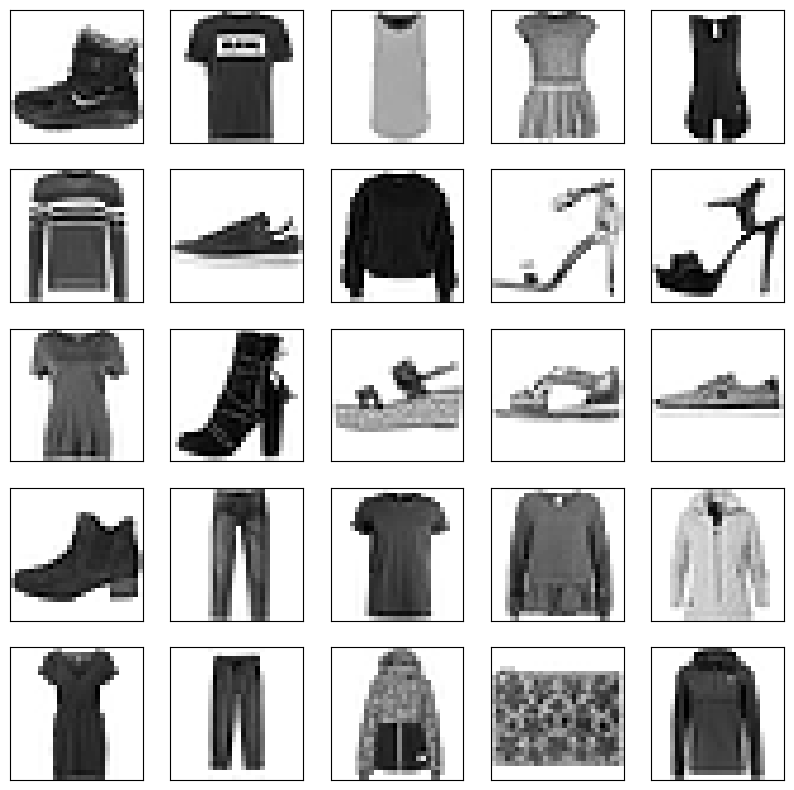

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i],cmap=plt.cm.binary)
    
plt.show()
    

## Creating batches of Training Data 

In [5]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)

2024-06-04 21:22:22.619391: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 21:22:22.619485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 21:22:22.619531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Building generator for DCGAN
    - Generator - An updampling netwrok with fractionally strided convolutions
    - Discriminator - A convolutional network

    - Archietecture:
        - Replacing pooling laeysr with strided convolutions and fractinal-strided convultions
        - Use batchnorm in btoh generator and discriminator
        - Remove fully connected hidden layesr for deepe architectres.
        - Use ReLU activation in generator for all layers except for the output which uses Tanh.
        - Using LeakyReLU in activation of discriminator


In [6]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense( 7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5),(2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1,(5,5),(2,2),padding ='same',activation='tanh')
    
    
])

/home/shashank/anaconda3/envs/Cuda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2024-06-04 21:22:22.973276: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


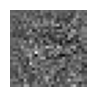

In [7]:
noise = tf.random.normal(shape=[1,num_features])
generated_image = generator(noise,training=False)

plot_utils.show(generated_image,1)

## Building Discriminator for DCGAN

In [8]:
# discriminator is simply a binary image classifier
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64,(5,5),(2,2), padding='same', input_shape=[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128,(5,5),(2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1,activation='sigmoid')
])

/home/shashank/anaconda3/envs/Cuda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
decision = discriminator (generated_image)
print(decision)


tf.Tensor([[0.500804]], shape=(1, 1), dtype=float32)


## Compiling DCGAN

In [10]:
discriminator.compile(loss='binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable=False
gan = keras.models.Sequential([generator,discriminator])
gan.compile(loss = 'binary_crossentropy', optimizer ='rmsprop')

## Training Procedure

In [11]:
seed = tf.random.normal(shape=[batch_size, num_features])

In [12]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [13]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator,discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch+1,epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size,num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images,X_batch], axis=0) 
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable =True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable =False
            gan.train_on_batch(noise,y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch,seed)

### Train DCGAN

In [14]:
x_train_dcgan = x_train.reshape(-1,28,28,1) * 2. -1.

In [15]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


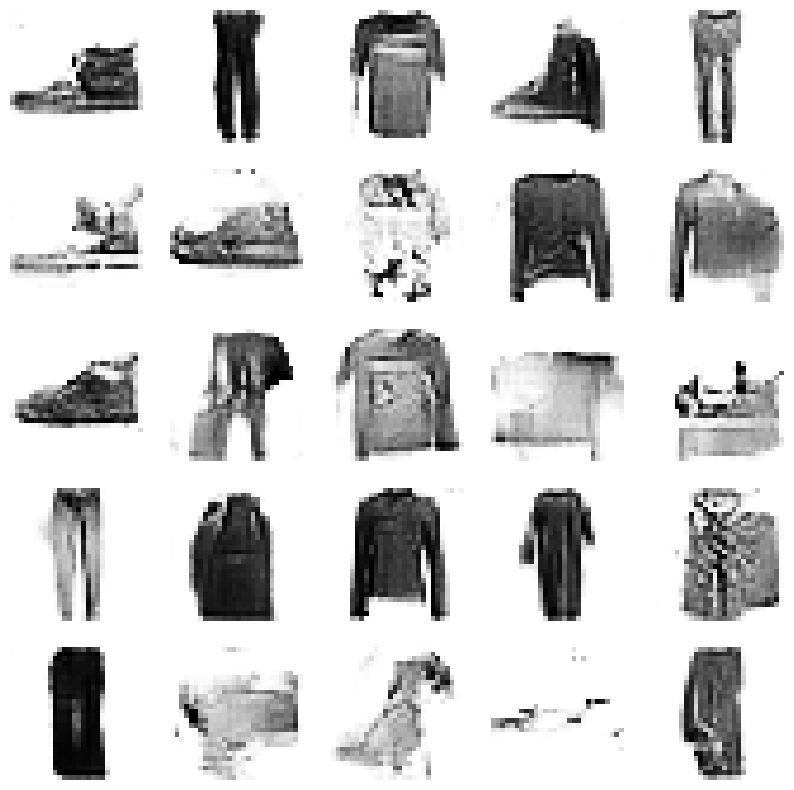

 40%|████      | 4/10 [40:09<1:09:16, 692.78s/it]

Epoch 5/10


In [16]:

train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

###
    - More layers and nodes can be added to both generator and discriminator 
    - train for more number of epochs
    - 